In [56]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
import umap.umap_ as umap

from sklearn.metrics import silhouette_score
from hdbscan.validity import validity_index
from itertools import product
import warnings
warnings.filterwarnings("ignore")

# 🔹 Đọc file dữ liệu
df_path = 'dataset_after_PCA_5PC.csv'
df = pd.read_csv(df_path)
df.head()


,PC1,PC2,PC3,PC4,PC5
0,1.924304,-0.334688,0.768643,-0.180139,-1.319931
1,1.935661,0.512652,0.584256,-0.007583,0.132323
2,1.963340,1.211678,0.609309,0.863300,0.007587
3,-1.083845,1.134463,0.586847,0.235003,0.446259
4,1.318977,1.669774,0.729905,0.126589,-0.103686


In [ ]:
# ==========================
# Giảm chiều bằng UMAP
# ==========================
print("📊 Giảm chiều dữ liệu bằng UMAP (2D để trực quan)...")

umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)

df_umap = umap_reducer.fit_transform(df)
print(f"✅ Dữ liệu sau UMAP: {df_umap.shape}")


📊 Giảm chiều dữ liệu bằng UMAP (2D để trực quan)...
✅ Dữ liệu sau UMAP: (440, 2)


In [58]:
# ==========================
# 3️⃣ Tuning tham số HDBSCAN
# ==========================
min_cluster_sizes = [5, 10, 15, 20, 30, 40, 50]
min_samples_list = [1, 5, 10, 15, 20, 25, 30]
metrics = ['euclidean', 'manhattan']

results = []

# Ép kiểu float64 để tránh lỗi DBCV
df_umap_64 = df_umap.astype(np.float64)

for mcs, ms, met in product(min_cluster_sizes, min_samples_list, metrics):
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=mcs,
        min_samples=ms,
        metric=met,
        cluster_selection_method='eom'
    ).fit(df_umap_64)

    labels = clusterer.labels_
    n_clusters = len(np.unique(labels[labels >= 0]))
    noise_ratio = np.mean(labels == -1)

    if n_clusters > 1:
        try:
            silhouette = silhouette_score(df_umap_64, labels)
        except:
            silhouette = np.nan
        try:
            dbcv = validity_index(df_umap_64, labels)
        except:
            dbcv = np.nan
    else:
        silhouette = dbcv = np.nan

    results.append({
        'min_cluster_size': mcs,
        'min_samples': ms,
        'metric': met,
        'n_clusters': n_clusters,
        'noise_ratio': round(noise_ratio, 3),
        'Silhouette': round(silhouette, 3),
        'DBCV': round(dbcv, 3)
    })

print("✅ Hoàn tất tuning tham số!")


✅ Hoàn tất tuning tham số!


In [59]:
# ==========================
# 4️⃣ Tổng hợp & chọn top 10 mô hình tốt nhất
# ==========================
results_df = pd.DataFrame(results)
top10 = results_df.sort_values(by=['DBCV', 'Silhouette'], ascending=[False, False]).head(10)

print("\n📈 Top 10 cấu hình tốt nhất (theo DBCV & Silhouette):")
print(top10)



📈 Top 10 cấu hình tốt nhất (theo DBCV & Silhouette):
    min_cluster_size  min_samples     metric  n_clusters  noise_ratio  \
71                40            1  manhattan           3        0.039   
84                50            1  euclidean           3        0.039   
85                50            1  manhattan           3        0.039   
12                 5           30  euclidean           3        0.061   
26                10           30  euclidean           3        0.061   
40                15           30  euclidean           3        0.061   
54                20           30  euclidean           3        0.061   
68                30           30  euclidean           3        0.061   
82                40           30  euclidean           3        0.061   
96                50           30  euclidean           3        0.061   

    Silhouette   DBCV  
71       0.458  0.561  
84       0.458  0.561  
85       0.458  0.561  
12       0.476  0.560  
26       0.476  0.560 

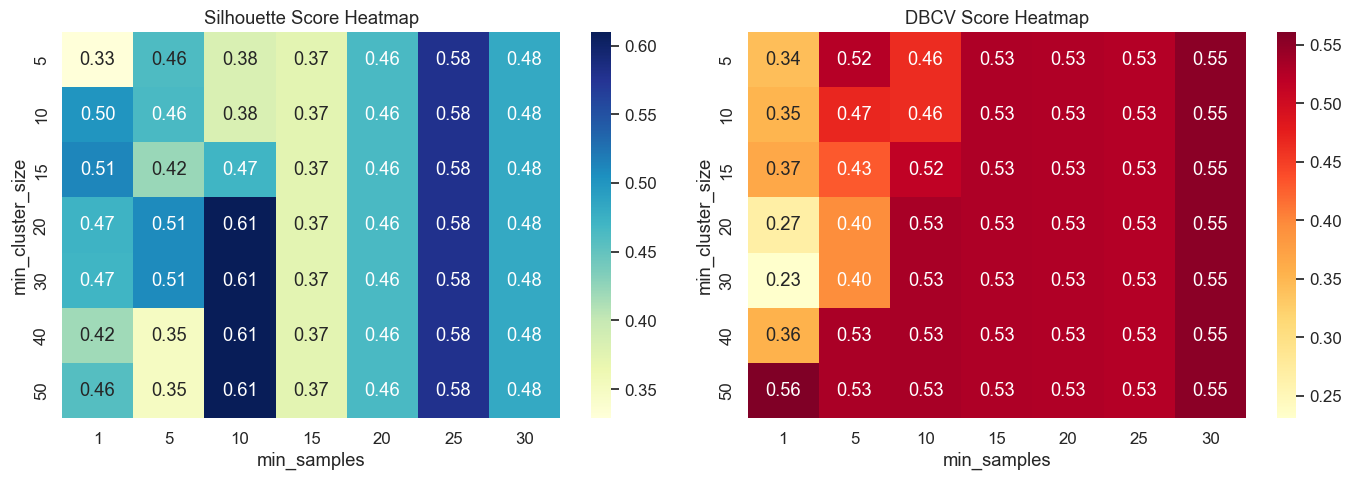

In [60]:
# ==========================
# 5️⃣ Heatmap trực quan
# ==========================
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
pivot_sil = results_df.pivot_table(index="min_cluster_size", columns="min_samples", values="Silhouette", aggfunc='mean')
pivot_dbcv = results_df.pivot_table(index="min_cluster_size", columns="min_samples", values="DBCV", aggfunc='mean')

sns.heatmap(pivot_sil, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax[0])
ax[0].set_title("Silhouette Score Heatmap")

sns.heatmap(pivot_dbcv, annot=True, fmt=".2f", cmap="YlOrRd", ax=ax[1])
ax[1].set_title("DBCV Score Heatmap")

plt.tight_layout()
plt.show()


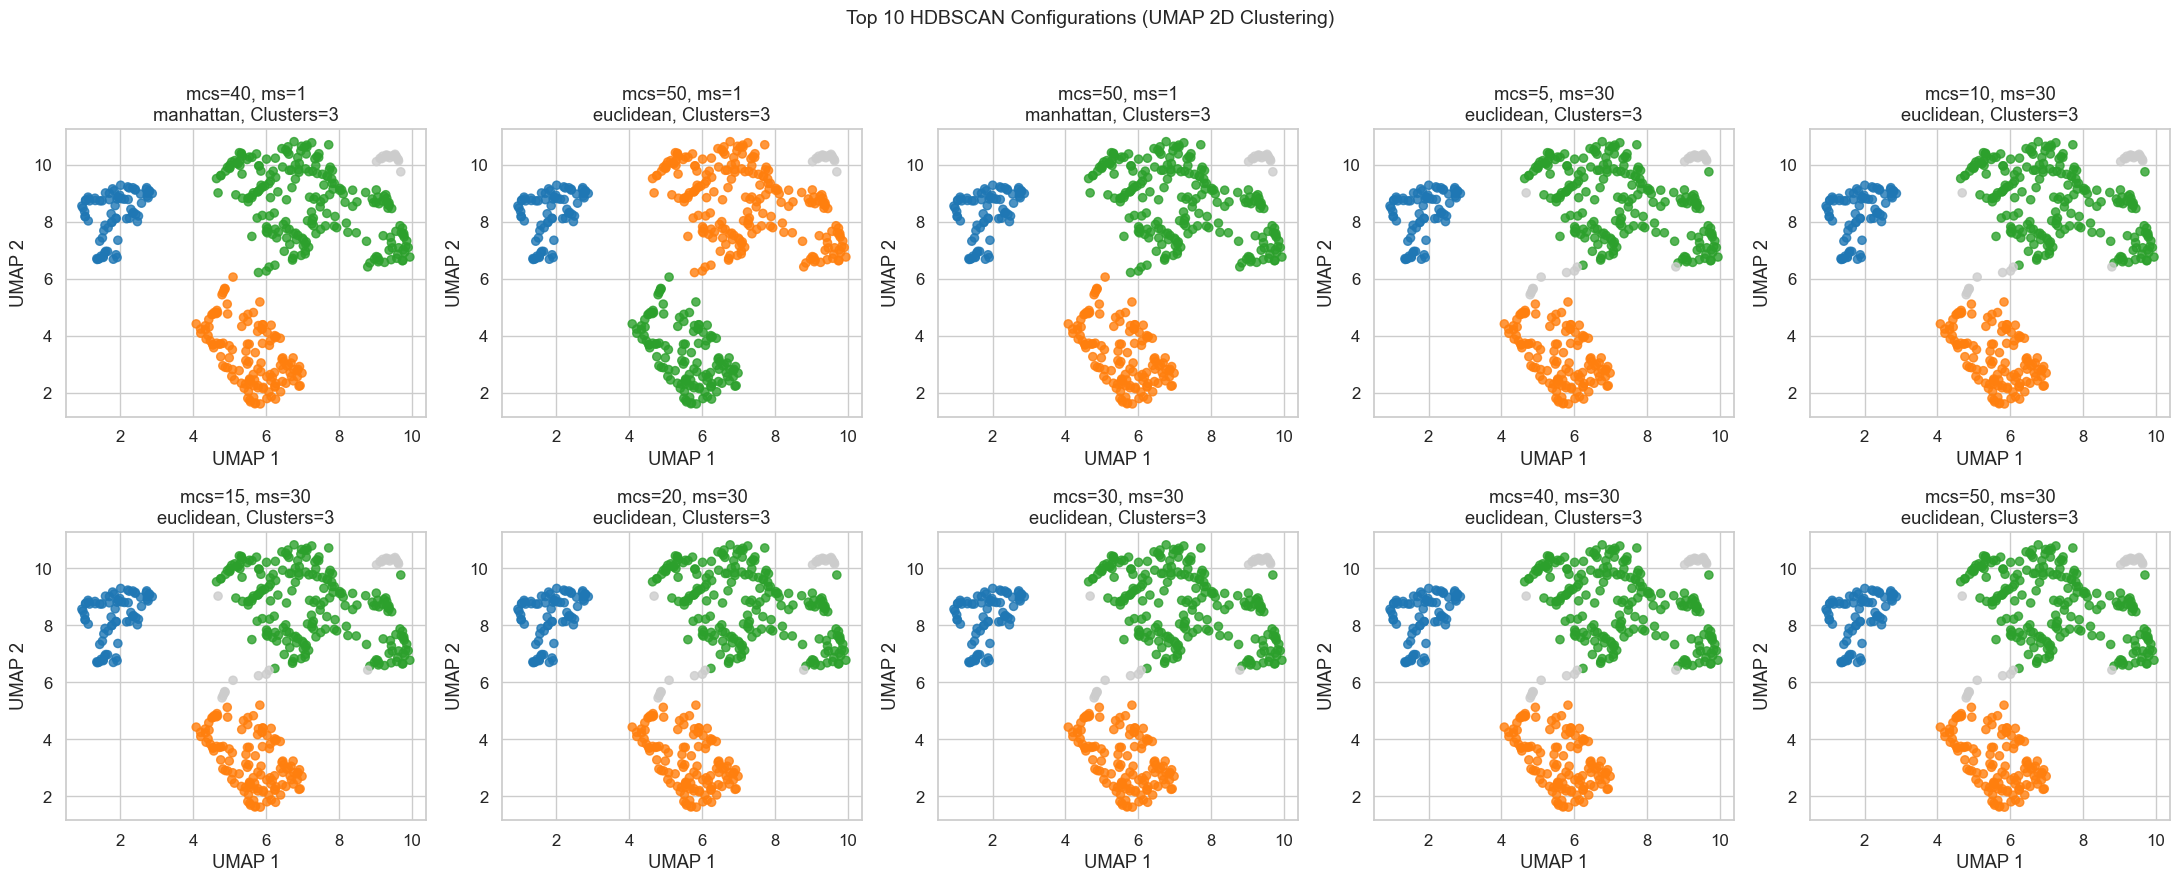

In [61]:
# ==========================
# 6️⃣ Vẽ 10 mô hình tốt nhất
# ==========================
fig, axes = plt.subplots(2, 5, figsize=(22, 9))
axes = axes.flatten()

for i, row in enumerate(top10.itertuples()):
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=int(row.min_cluster_size),
        min_samples=int(row.min_samples),
        metric=row.metric
    ).fit(df_umap)

    labels = clusterer.labels_
    n_clusters = len(np.unique(labels[labels >= 0]))
    palette = sns.color_palette("tab10", len(np.unique(labels[labels >= 0])))
    colors = [palette[x] if x >= 0 else (0.8, 0.8, 0.8) for x in labels]

    ax = axes[i]
    ax.scatter(df_umap[:, 0], df_umap[:, 1], c=colors, s=35, alpha=0.8)
    ax.set_title(f"mcs={row.min_cluster_size}, ms={row.min_samples}\n{row.metric}, Clusters={n_clusters}")
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")

plt.suptitle("Top 10 HDBSCAN Configurations (UMAP 2D Clustering)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



✅ Mô hình tốt nhất:
min_cluster_size           40
min_samples                 1
metric              manhattan
n_clusters                  3
noise_ratio             0.039
Silhouette              0.458
DBCV                    0.561
Name: 71, dtype: object

Số cụm tìm được: 3


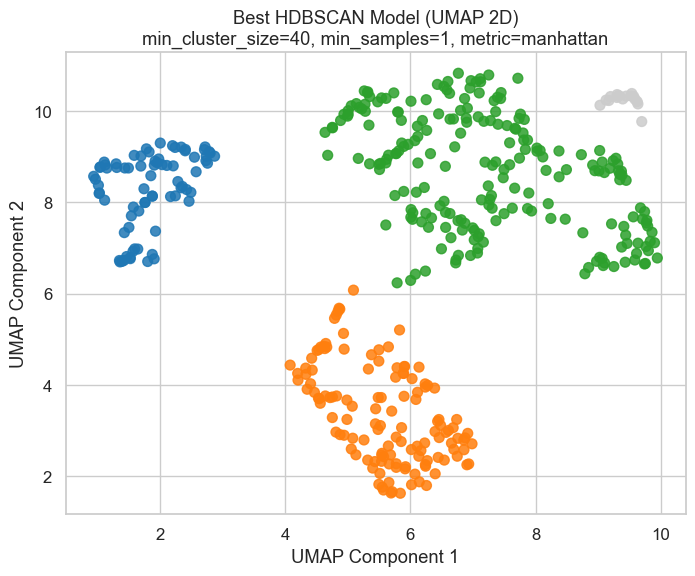

In [62]:
# ==========================
# 7️⃣ Mô hình tốt nhất chi tiết
# ==========================
best_row = top10.iloc[0]
print(f"\n✅ Mô hình tốt nhất:")
print(best_row)

best_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=int(best_row['min_cluster_size']),
    min_samples=int(best_row['min_samples']),
    metric=best_row['metric']
).fit(df_umap)

labels = best_clusterer.labels_
n_clusters = len(np.unique(labels[labels >= 0]))
print(f"\nSố cụm tìm được: {n_clusters}")

palette = sns.color_palette("tab10", len(np.unique(labels[labels >= 0])))
colors = [palette[x] if x >= 0 else (0.8, 0.8, 0.8) for x in labels]

plt.figure(figsize=(8, 6))
plt.scatter(df_umap[:, 0], df_umap[:, 1], c=colors, s=50, alpha=0.85)
plt.title(f"Best HDBSCAN Model (UMAP 2D)\nmin_cluster_size={int(best_row['min_cluster_size'])}, min_samples={int(best_row['min_samples'])}, metric={best_row['metric']}")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()
